In [1]:
import pandas as pd
import torch

In [2]:
import os
os.chdir('..')
from team_functions import dataPrep, getTeamRollingSeason, mapTeamID
from models import *

In [3]:
prev_odds = pd.read_excel('Predictions/games_odds.xlsx', sheet_name='Previous')

In [4]:
games_to_pred = []
teams, opps = prev_odds['visitor'], prev_odds['local']
for team, opp in zip(teams, opps):
    team_row = {}
    team_df = pd.read_excel(f'data/CurrentSeason/{team}.xlsx')
    
    team_row['Game'] = team_df['Game'].iloc[-1] + 1
    team_row['Date'] = prev_odds.loc[prev_odds['visitor'] == team, 'date'].iloc[0]
    team_row['Streak'] = team_df['Streak'].iloc[-1]

    team_cols = ['Pts', 'Pace', 'eFG', 'TOV', 'ORB', 'FTR', 'ORT']
    for col in team_cols:
        team_row[col] = team_df[col].mean()

    opp_df = pd.read_excel(f'data/CurrentSeason/{opp}.xlsx')
    team_row['OppID'] = mapTeamID(opp)
    
    opp_cols = ['Pts', 'eFG', 'TOV', 'ORB', 'FTR', 'ORT']
    for col in opp_cols:
        team_row['Opp'+col] = opp_df[col].mean()
        
    team_row['Location'] = 0
    
    team_row['Month'] = team_row['Date'].month
    team_row['DayOfWeek'] = team_row['Date'].weekday()
    team_row['DaysOfRest'] = (team_row['Date'] - team_df['Date'].iloc[-1]).days
    
    team_row['TeamID'] = mapTeamID(team)
    
    games_to_pred.append(team_row)
    
games_df = pd.DataFrame(games_to_pred)

In [5]:
games_df.head()

,Game,Date,Streak,Pts,Pace,eFG,TOV,ORB,FTR,ORT,...,OppeFG,OppTOV,OppORB,OppFTR,OppORT,Location,Month,DayOfWeek,DaysOfRest,TeamID
0,61,2024-02-03,2,112.166667,96.820000,0.535000,10.701667,24.776667,0.174333,115.206667,...,0.535617,9.950000,24.925000,0.238467,119.496667,0,2,5,-28,3
1,61,2024-02-03,-1,118.583333,99.143333,0.553967,12.080000,27.445000,0.185417,118.431667,...,0.537883,10.836667,27.643333,0.216800,119.025000,0,2,5,-29,10
2,60,2024-02-03,1,118.203390,99.008475,0.563983,11.208475,23.567797,0.172356,118.089831,...,0.529967,10.588333,24.661667,0.188283,115.048333,0,2,5,-27,26
3,63,2024-02-03,-1,117.129032,100.117742,0.562161,11.716129,19.470968,0.210306,115.966129,...,0.538820,11.039344,29.522951,0.201852,118.972131,0,2,5,-28,14
4,62,2024-02-03,5,121.491803,100.280328,0.573689,10.929508,21.886885,0.221180,120.532787,...,0.563885,10.657377,22.173770,0.198393,119.018033,0,2,5,-27,17


In [6]:
import joblib
import matplotlib.pyplot as plt

In [7]:
def makeModelPredictions(games_df, odds_df, model_name, show=True):
    if model_name == 'RNN':
        model = torch.load('TemporalModels/TrainedModels/RNN.pt')
        scaler = joblib.load(f'TemporalModels/Scalers/RNN.pkl')
        
    else:
        model = joblib.load(f'TemporalModels/TrainedModels/{model_name}_Model.pkl')
        scaler = joblib.load(f'TemporalModels/Scalers/{model_name}.bin')
        
    
    scaled_df = scaler.transform(games_df.drop(columns=['Date']))
    if model_name == 'RNN':
        scaled_df = torch.FloatTensor(scaled_df)
        predictions = torch.round(model(scaled_df).squeeze(1))
        predictions = predictions.detach().numpy()
    else:
        predictions = model.predict(scaled_df)
    
    odds_df['Predictions'] = predictions
    if show:
        print(f'Predictions made by: {model_name}')
        display(odds_df.head())
        
    return odds_df

Predictions made by: LR


,date,visitor,local,v_line,l_line,Results,Predictions
0,2024-02-03,BRK,PHI,2.420000,1.588235,1,0
1,2024-02-03,GSW,ATL,2.200000,1.704225,0,0
2,2024-02-03,SAC,CHI,2.050000,1.800000,1,0
3,2024-02-03,LAL,NYK,2.640000,1.505051,1,0
4,2024-02-03,MIL,DAL,1.540541,2.540000,1,0


# of bets win: 21
% of bets win: 29.166666666666668
Final Balance: 13.719955642000208


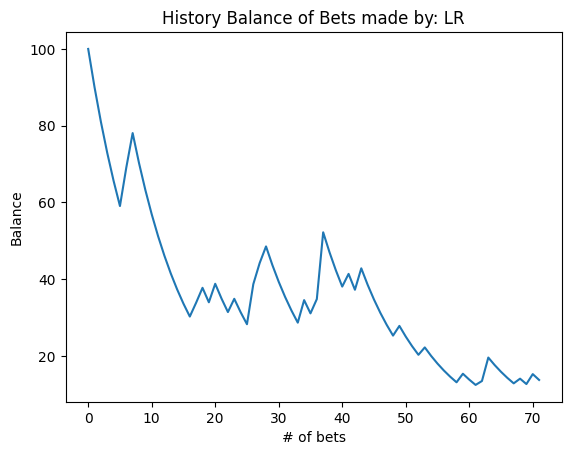

In [15]:
model_name = 'LR'
model_preds = makeModelPredictions(games_df, prev_odds, model_name)

balance = 100
history = [balance]
n_wins = 0
win_history = [n_wins]

for game_idx in range(model_preds.shape[0]):
    row = prev_odds.iloc[game_idx]
    
    prediction = row['Predictions']
    result = row['Results']
    
    if prediction == 1:
        line = row['v_line']
    elif prediction == 0:
        line = row['l_line']
    
    if line > 1.8:
        bet = balance * 0.1
        balance -= bet
        if prediction == result:
            income = bet*line
            balance += income
            n_wins += 1

        win_history.append(n_wins)
        history.append(balance)

plt.xlabel('# of bets')
plt.ylabel('Balance')
plt.title(f'History Balance of Bets made by: {model_name}')
plt.plot(history)
print(f'# of bets win: {win_history[-1]}')
print(f'% of bets win: {(win_history[-1]/len(win_history))*100}')
print(f'Final Balance: {history[-1]}')

Predictions made by: GB


,date,visitor,local,v_line,l_line,Results,Predictions
0,2024-02-03,BRK,PHI,2.420000,1.588235,1,0
1,2024-02-03,GSW,ATL,2.200000,1.704225,0,0
2,2024-02-03,SAC,CHI,2.050000,1.800000,1,0
3,2024-02-03,LAL,NYK,2.640000,1.505051,1,1
4,2024-02-03,MIL,DAL,1.540541,2.540000,1,0


# of bets win: 17
% of bets win: 37.77777777777778
Final Balance: 43.35576924843499


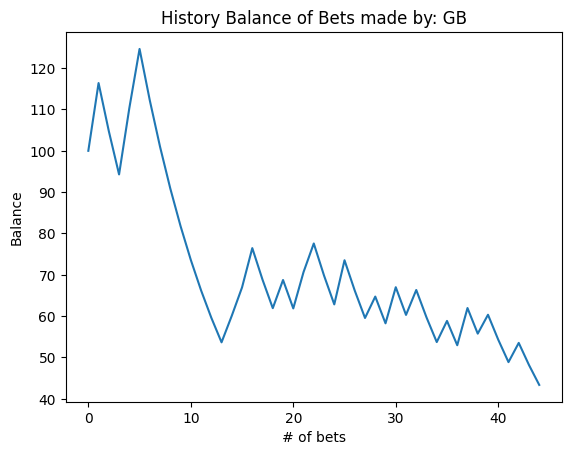

In [14]:
model_name = 'GB'
model_preds = makeModelPredictions(games_df, prev_odds, model_name)

balance = 100
history = [balance]
n_wins = 0
win_history = [n_wins]

for game_idx in range(model_preds.shape[0]):
    row = prev_odds.iloc[game_idx]
    
    prediction = row['Predictions']
    result = row['Results']
    
    if prediction == 1:
        line = row['v_line']
    elif prediction == 0:
        line = row['l_line']
    
    if line > 1.8:
        bet = balance * 0.1
        balance -= bet
        if prediction == result:
            income = bet*line
            balance += income
            n_wins += 1

        win_history.append(n_wins)
        history.append(balance)

plt.xlabel('# of bets')
plt.ylabel('Balance')
plt.title(f'History Balance of Bets made by: {model_name}')
plt.plot(history)
print(f'# of bets win: {win_history[-1]}')
print(f'% of bets win: {(win_history[-1]/len(win_history))*100}')
print(f'Final Balance: {history[-1]}')

Predictions made by: RNN


,date,visitor,local,v_line,l_line,Results,Predictions
0,2024-02-03,BRK,PHI,2.420000,1.588235,1,0.0
1,2024-02-03,GSW,ATL,2.200000,1.704225,0,0.0
2,2024-02-03,SAC,CHI,2.050000,1.800000,1,0.0
3,2024-02-03,LAL,NYK,2.640000,1.505051,1,0.0
4,2024-02-03,MIL,DAL,1.540541,2.540000,1,0.0


# of bets win: 21
% of bets win: 29.166666666666668
Final Balance: 13.719955642000208


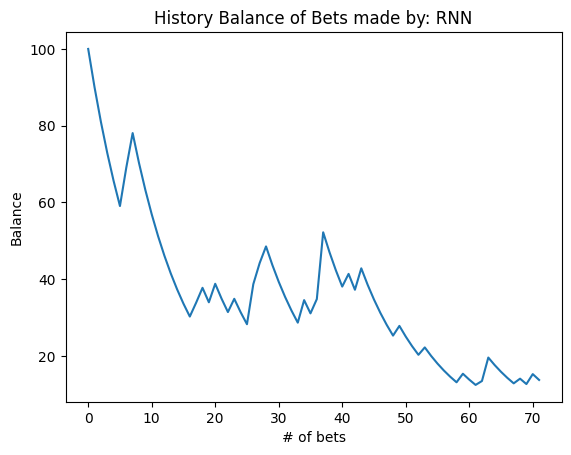

In [13]:
model_name = 'RNN'
model_preds = makeModelPredictions(games_df, prev_odds, model_name)

balance = 100
history = [balance]
n_wins = 0
win_history = [n_wins]

for game_idx in range(model_preds.shape[0]):
    row = prev_odds.iloc[game_idx]
    
    prediction = row['Predictions']
    result = row['Results']
    
    if prediction == 1:
        line = row['v_line']
    elif prediction == 0:
        line = row['l_line']
    
    if line > 1.8:
        bet = balance * 0.1
        balance -= bet
        if prediction == result:
            income = bet*line
            balance += income
            n_wins += 1

        win_history.append(n_wins)
        history.append(balance)

plt.xlabel('# of bets')
plt.ylabel('Balance')
plt.title(f'History Balance of Bets made by: {model_name}')
plt.plot(history)
print(f'# of bets win: {win_history[-1]}')
print(f'% of bets win: {(win_history[-1]/len(win_history))*100}')
print(f'Final Balance: {history[-1]}')